# India Experiments

In [1]:
%load_ext autoreload
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

base_dir = Path(".").absolute().parents[0]
assert base_dir.name == "spatio_temporal"
import sys

if sys.path[0] != base_dir.as_posix():
    sys.path = [base_dir.as_posix()] + sys.path

In [2]:
from spatio_temporal.config import Config
from spatio_temporal.training.trainer import Trainer
from spatio_temporal.training.tester import Tester
from tests.utils import (
    create_linear_ds,
    _test_sklearn_model,
    get_pollution_data_beijing,
    create_test_oxford_run_data
)
from spatio_temporal.training.eval_utils import _plot_loss_curves, save_losses

# Load in Data
```python
ds2 = ds.resample(time="M").reduce(np.mean)
ds2.to_netcdf(base_dir / "data/data_india_full.nc")
```

['VCI', 'swvl1', 'swvl2', 'swvl3', 'swvl4', 'pev', 'tp', 't2m', 'e', 't2m_std_1', 't2m_mean_1', 't2m_std_2', 't2m_mean_2', 't2m_std_3', 't2m_mean_3', 'erate_std_1', 'erate_mean_1', 'erate_std_2', 'erate_mean_2', 'erate_std_3', 'erate_mean_3', 'tprate_std_1', 'tprate_mean_1', 'tprate_std_2', 'tprate_mean_2', 'tprate_std_3', 'tprate_mean_3', 'modis_vci']


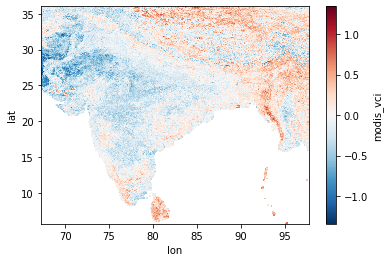

In [3]:
ds = xr.open_dataset(base_dir / "data/data_india_full.nc").sortby("time")
ds["modis_vci"].mean(dim='time').plot()

print(list(ds.data_vars))

# check the config

In [4]:
cfg = Config(base_dir / "configs/india.yml")
cfg._cfg["n_epochs"] = 3

In [5]:
from spatio_temporal.data.data_utils import _check_no_missing_times_in_time_series

# Work with subset of data

In [6]:
subset = ds.isel(lat=slice(0, 5), lon=slice(0, 5))

In [7]:
print("Loading Trainer")
trainer = Trainer(cfg, subset)

Loading Trainer


Loading Data: 100%|██████████| 25/25 [00:00<00:00, 477.56it/s]


In [8]:
losses = trainer.train_and_validate()

Training Epoch 2:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 0.44
Valid Loss: 0.42


Training Epoch 3:   0%|          | 0/38 [00:00<?, ?it/s]

Train Loss: 0.44
Valid Loss: 0.42


Validation Epoch 3: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

Train Loss: 0.43
Valid Loss: 0.41


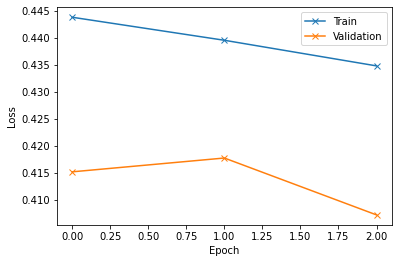

In [9]:
from spatio_temporal.training.eval_utils import _plot_loss_curves

_plot_loss_curves(losses);

Test set Forward Pass: 100%|██████████| 8/8 [00:02<00:00,  2.90it/s]


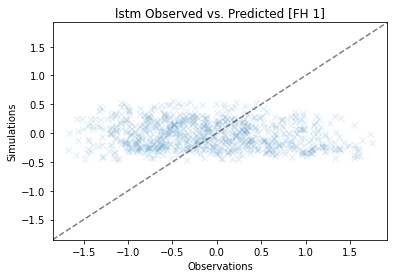

In [10]:
tester = Tester(cfg, subset)
preds = tester.run_test(unnormalize=True)

# Check hold-out test performance

In [3]:
cfg = Config(base_dir / "configs/india.yml")
cfg.run_dir = Path("/Users/tommylees/github/spatio_temporal/notebooks/runs/india_initial_1803_150619")

In [4]:
xr_path = sorted(list(cfg.run_dir.glob("*.nc")))[-1]
preds = xr.open_dataset(xr_path).drop("horizon")
preds

<xarray.Dataset>
Dimensions:  (pixel: 25, time: 31)
Coordinates:
  * time     (time) datetime64[ns] 2016-05-31T00:00:42.290642944 ... 2018-11-...
  * pixel    (pixel) object '35.599998474121094_67.30000305175781' ... '36.0_...
Data variables:
    sim      (time, pixel) float64 ...
    obs      (time, pixel) float64 ...

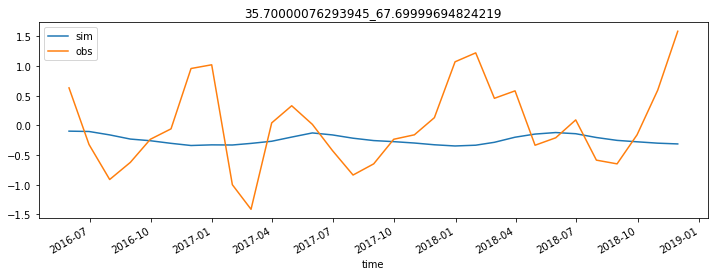

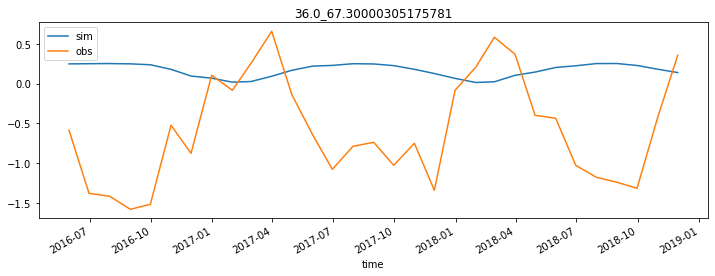

In [5]:
for i in np.arange(2):
    f, ax = plt.subplots(figsize=(12, 4))
    pixel = np.random.choice(preds.pixel.values)
    preds.sel(pixel=pixel).to_dataframe().plot(ax=ax)
    ax.set_title(pixel)

In [47]:
# from ml_drought
import sys; sys.path.append("/Users/tommylees/github/ml_drought")
import sys; sys.path.append("/Users/tommylees/github/neuralhydrology")
from scripts.drafts.calculate_error_scores import calculate_all_data_errors, get_metric_dataframes_from_output_dict
from spatio_temporal.data.data_utils import unstack_xarray


errors = calculate_all_data_errors(
    preds.rename({"pixel":"station_id"}), decompose_kge=False, yilmaz_errors=True
)["sim"].to_xarray().rename({"station_id": "pixel"})
spatial_errors = unstack_xarray(errors, sample_str="pixel")

ImportError: cannot import name 'unstack_xarray' from 'spatio_temporal.data.data_utils' (/Users/tommylees/github/spatio_temporal/spatio_temporal/data/data_utils.py)